Import Libraries and the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
data =  pd.read_csv('/content/prices.csv', header=0)

In [3]:
data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
print(data.columns)
print(data.shape)

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')
(693126, 7)


In [5]:
data.iloc[:, 2:-1].describe()

,open,close,low,high
count,693126.000000,693125.000000,693125.000000,693125.000000
mean,67.529079,67.543619,66.844504,68.199281
std,78.188632,78.174073,77.417323,78.910285
min,0.850000,0.860000,0.830000,0.880000
25%,32.959999,32.970001,32.599998,33.310001
50%,50.910000,50.919998,50.380001,51.419998
75%,76.660004,76.680000,75.930002,77.379997
max,1382.609985,1370.430054,1361.099976,1395.000000


In [6]:
  data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693126 entries, 0 to 693125
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    693126 non-null  object 
 1   symbol  693126 non-null  object 
 2   open    693126 non-null  float64
 3   close   693125 non-null  float64
 4   low     693125 non-null  float64
 5   high    693125 non-null  float64
 6   volume  693125 non-null  float64
dtypes: float64(5), object(2)
memory usage: 37.0+ MB


Number of unique stock symbols

In [7]:
print(len(data['symbol'].unique()))
symbols = data['symbol'].unique()

498


In [8]:
data['symbol'].describe()

count     693126
unique       498
top         COST
freq        1446
Name: symbol, dtype: object

Choosing a Random Stock Symbol

In [9]:
choosen_symbol = random.choice(symbols)
print(choosen_symbol)

PBI


In [10]:
data_prices = data[data['symbol'] == choosen_symbol].reset_index(drop = True)
data_prices.iloc[:10, :]

,date,symbol,open,close,low,high,volume
0,2010-01-04,PBI,22.879999,22.920000,22.650000,22.990000,2040000.0
1,2010-01-05,PBI,22.930000,22.020000,21.750000,22.930000,4240700.0
2,2010-01-06,PBI,22.080000,22.240000,22.000000,22.290001,2654900.0
3,2010-01-07,PBI,22.240000,22.270000,22.100000,22.320000,1886800.0
4,2010-01-08,PBI,22.270000,22.270000,22.150000,22.280001,1887500.0
5,2010-01-11,PBI,22.360001,21.940001,21.860001,22.370001,2464300.0
6,2010-01-12,PBI,21.860001,22.110001,21.860001,22.219999,2380500.0
7,2010-01-13,PBI,22.219999,22.270000,22.049999,22.320000,1772100.0
8,2010-01-14,PBI,22.370001,22.260000,22.139999,22.370001,1133900.0
9,2010-01-15,PBI,22.320000,21.930000,21.860001,22.320000,1813000.0


In [11]:
data_prices = data_prices.drop(['date', 'symbol'], axis=1)

Plotting Price through Time

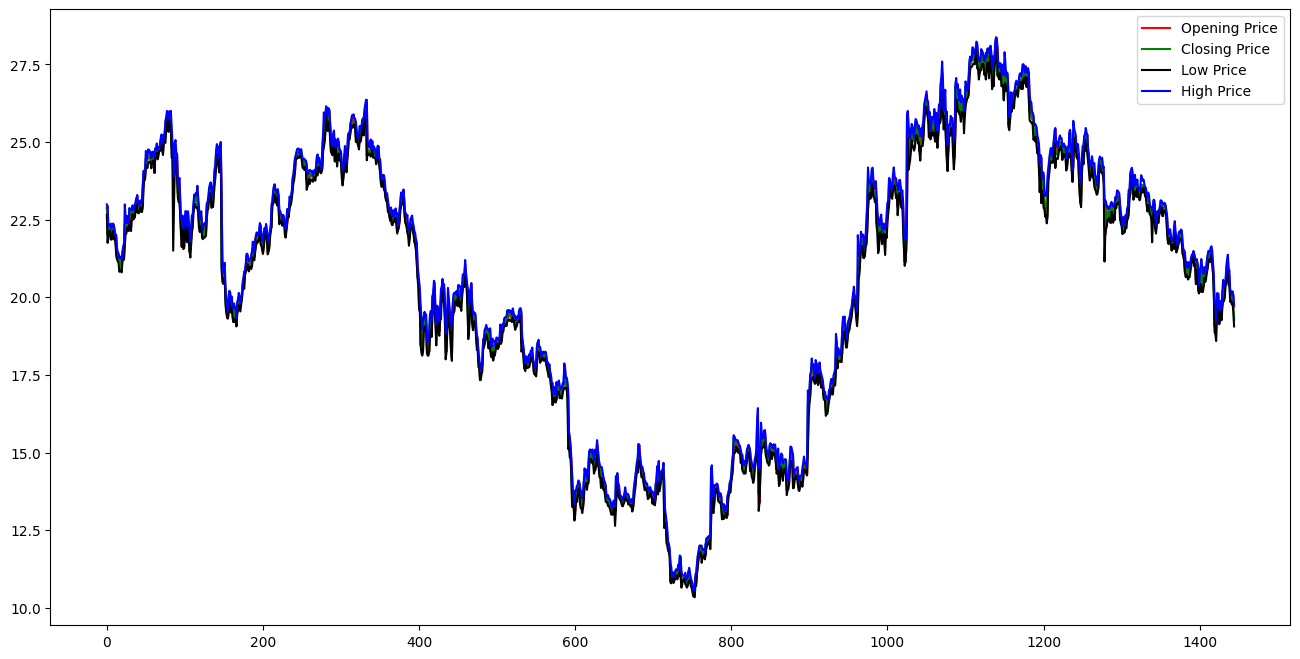

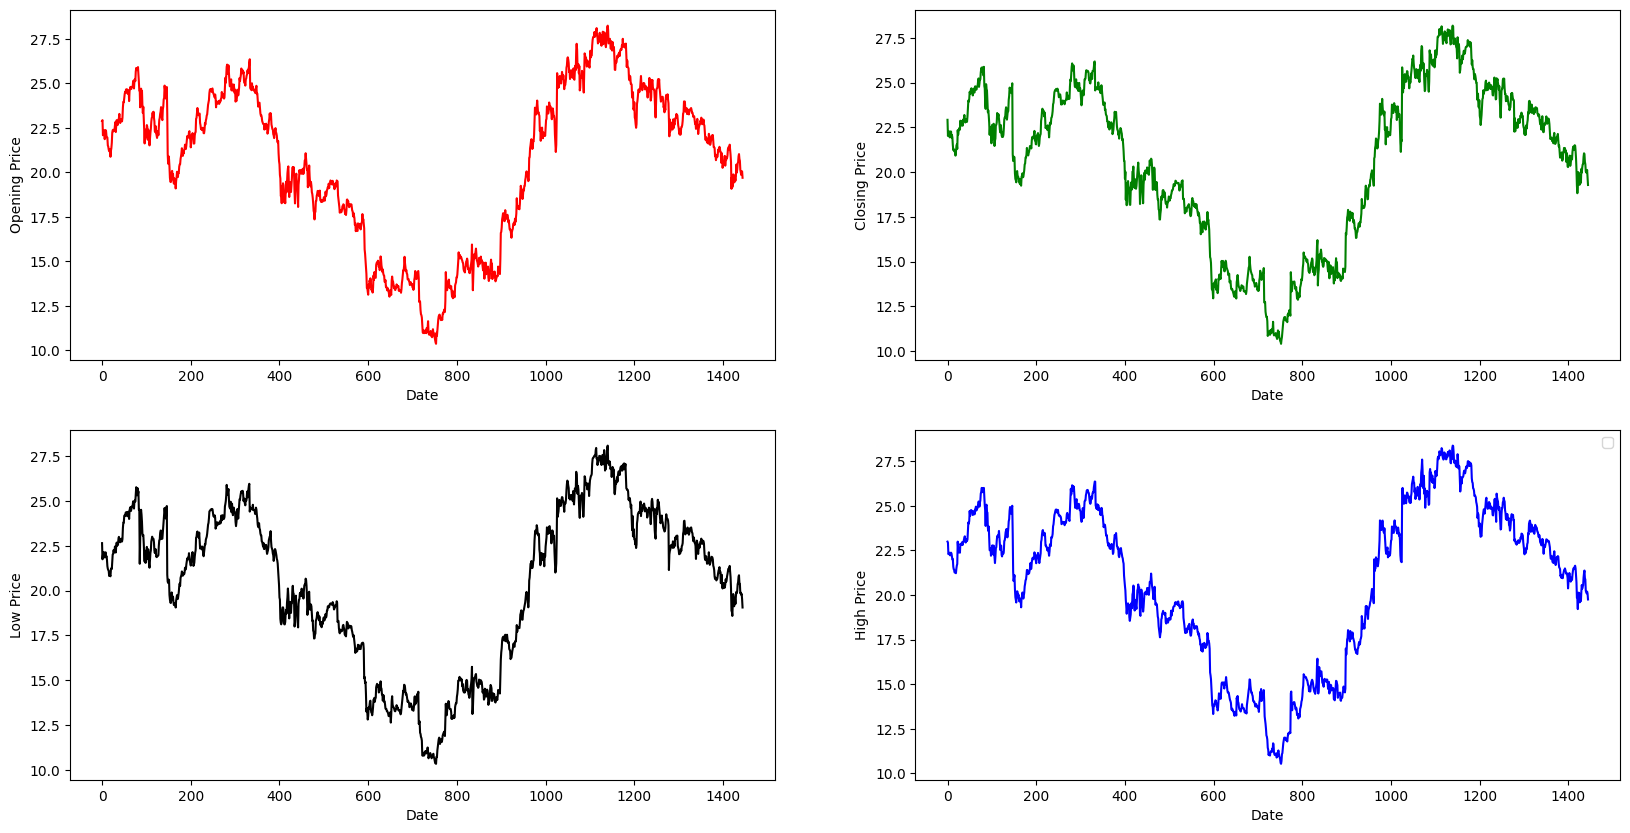

In [12]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(data_prices['open'], color='red', label = 'Opening Price')
plt.plot(data_prices['close'], color='green', label = 'Closing Price')
plt.plot(data_prices['low'], color='black', label = 'Low Price')
plt.plot(data_prices['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data_prices['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data_prices['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(data_prices['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(data_prices['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

In [13]:
data_prices = data_prices.drop(['close', 'low', 'high'], axis=1)

Feature Scaling

In [14]:
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)

In [15]:
data_prices_scaled.shape

(1445, 2)

Creating LSTM input data

In [16]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])

    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [18]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1136, 25, 2)
(284, 25, 2)
(1136, 1)
(284, 1)


Train LSTM Model

In [19]:
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1216      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3345 (13.07 KB)
Trainable params: 3345 (13.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
13/13 [==============================] - 5s 101ms/step - loss: 0.1267 - root_mean_squared_error: 0.3559 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2075
Epoch 2/40
13/13 [==============================] - 0s 28ms/step - loss: 0.0298 - root_mean_squared_error: 0.1726 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 3/40
13/13 [==============================] - 0s 30ms/step - loss: 0.0203 - root_mean_squared_error: 0.1427 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1608
Epoch 4/40
13/13 [==============================] - 0s 28ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 5/40
13/13 [==============================] - 0s 30ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1011
Epoch 6/40
13/13 [==============================] - 0s 30ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0070 - val_root_

In [21]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

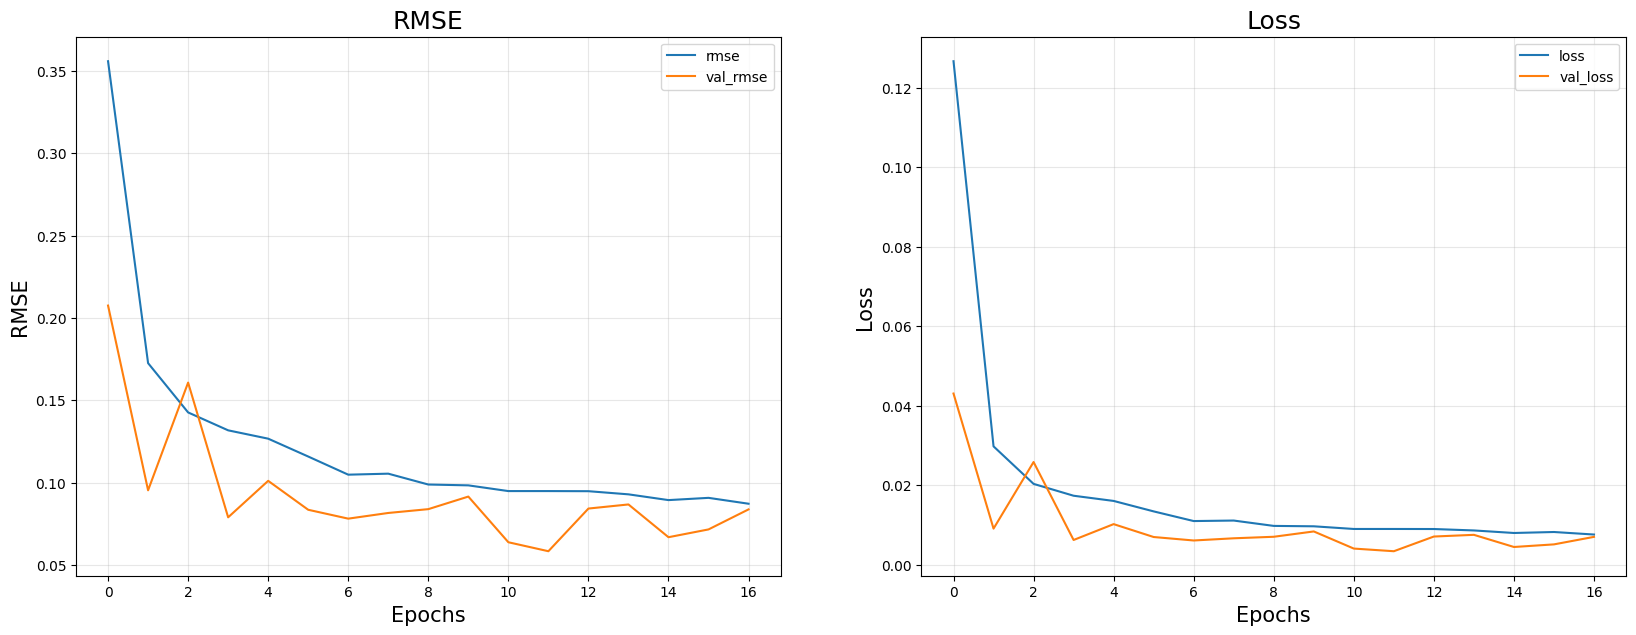

In [22]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [23]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

9/9 [==============================] - 0s 9ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383
test loss, test acc: [0.0015 0.0383]


Hyperparameter training

In [24]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [25]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00781, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.00781 to 0.00417, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00417 to 0.00306, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00306

Epoch 5: val_loss did not improve from 0.00306

Epoch 6: val_loss did not improve from 0.00306

Epoch 7: val_loss did not improve from 0.00306

Epoch 8: val_loss did not improve from 0.00306
Epoch 8: early stopping
0-th combination = (False, False, False, 16, 8, 0.2) 
 train accuracy: [0.003923572134226561, 0.06263842433691025] and test accuracy: [0.0017622278537601233, 0.041978899389505386]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improve

Choosing the best model

In [27]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
2,False,False,False,16,32,0.2,"[0.0030248817056417465, 0.05499892309308052]","[0.0012942813336849213, 0.03597612306475639]"
5,False,False,False,32,32,0.2,"[0.003404163056984544, 0.05834520608186722]","[0.001547647756524384, 0.03934015333652496]"
0,False,False,False,16,8,0.2,"[0.003923572134226561, 0.06263842433691025]","[0.0017622278537601233, 0.041978899389505386]"
4,False,False,False,32,16,0.2,"[0.003988884389400482, 0.06315761804580688]","[0.0018059168942272663, 0.042496081441640854]"
1,False,False,False,16,16,0.2,"[0.004277372267097235, 0.06540162116289139]","[0.0022480131592601538, 0.04741321876645088]"
3,False,False,False,32,8,0.2,"[0.0041405088268220425, 0.0643467828631401]","[0.002288202289491892, 0.047835156321525574]"


Results

In [28]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 32
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0383

Results After Tunning:
 Test Set RMSE: 0.036

6.0% Improvement


In [29]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [30]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 1: val_loss improved from inf to 0.01129, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.01129 to 0.00440, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00440

Epoch 4: val_loss did not improve from 0.00440

Epoch 5: val_loss did not improve from 0.00440

Epoch 6: val_loss did not improve from 0.00440

Epoch 7: val_loss improved from 0.00440 to 0.00280, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.00280

Epoch 9: val_loss did not improve from 0.00280

Epoch 10: val_loss did not improve from 0.00280

Epoch 11: val_loss did not improve from 0.00280

Epoch 12: val_loss did not improve from 0.00280
Epoch 12: early stopping


In [31]:
regressor.evaluate(X_test, y_test)

9/9 [==============================] - 0s 10ms/step - loss: 0.0013


0.001329981372691691

9/9 [==============================] - 2s 11ms/step


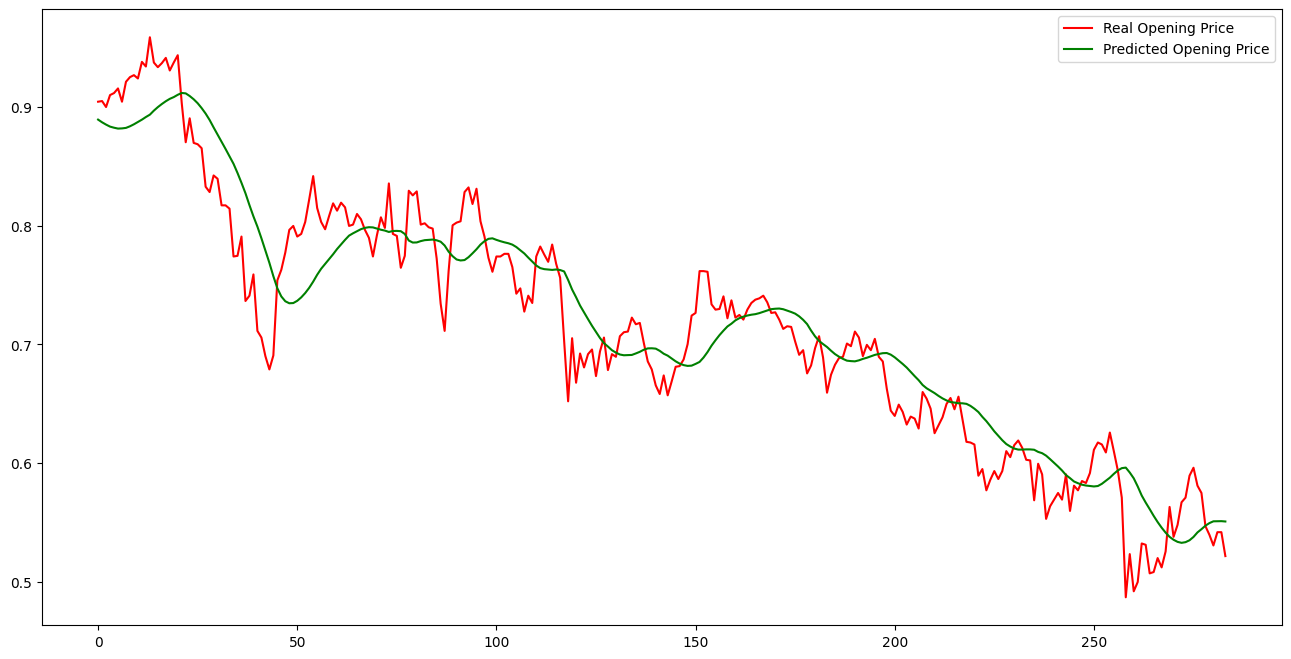

In [32]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='green', label = 'Predicted Opening Price')
plt.legend(loc='best')